# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
# import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data_tools.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics
from lib.criterion.loss import RMSELoss

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=3,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          lgbm_a=2.998,
          lgbm_b=1.092,
          lgbm_n_folds=25,
          max_grad_norm=1000,
          max_length=1024,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=7,
          negative_sample=False,
          negative_sample_partitions=3,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          positive_classes=[0, 5],
          negative_classes=[1, 2, 3, 4],
          print_freq=6,
          random_seed=20,
          regression=True,
          scheduler='cosine',
          stride=384,
          tokenizer_v

In [5]:
seed_everything()

### Setting Up WandB

In [6]:
# WANDB_PROJECT = "Kaggle_ASE_2.0"
# model_name = config.model.split("/")[-1]
# WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [7]:
# wandb.login(key=os.environ.get('WANDB_API_KEY'))
# wandb.init(
#     project=WANDB_PROJECT,
#     name=WANDB_NAME,
#     save_code=True,
#     job_type="train",
#     config=config,
# )
# config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [7]:
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

### 🛠️ Functions

In [10]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )

    # ======= LOSS ==========
    criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            fold, valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, pred_scores = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, pred_scores)

        # wandb.log(
        #     {
        #         f"eval/eval_epoch_f{fold}": epoch + 1,
        #         f"eval/eval_loss_f{fold}": avg_val_loss,
        #         f"eval/qwk_score_f{fold}": score,
        #     }
        # )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                os.path.join(
                    Paths.MODEL_OUTPUT_PATH,
                    f"{config.model.replace('/', '_')}_fold_{fold}_best.pth",
                ),
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    predictions = softmax(torch.tensor(predictions))
    _, pred_scores = torch.max(predictions, dim=1)
    valid_fold["pred_score"] = pred_scores

    for i in range(config.num_classes):
        valid_fold[f"score_prob_{i}"] = predictions[:, i]

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [11]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [12]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    # wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 126/126 [00:19<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.0710  avg_val_loss: 1.1585  time: 414s
Epoch 1 - Score: 0.7389
Epoch 1 - Save Best Score: 0.7389 Model


Validating Fold 0: 100%|██████████| 126/126 [00:20<00:00,  6.06valid_batch/s]


Epoch 2 - avg_train_loss: 0.8814  avg_val_loss: 0.9173  time: 422s
Epoch 2 - Score: 0.8024
Epoch 2 - Save Best Score: 0.8024 Model
========== Fold: 0 result ==========
Score: 0.8024
========== Fold: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 122/122 [00:19<00:00,  6.24valid_batch/s]


Epoch 1 - avg_train_loss: 1.0410  avg_val_loss: 1.0352  time: 447s
Epoch 1 - Score: 0.7551
Epoch 1 - Save Best Score: 0.7551 Model


Validating Fold 1: 100%|██████████| 122/122 [00:19<00:00,  6.11valid_batch/s]


Epoch 2 - avg_train_loss: 0.8603  avg_val_loss: 1.1092  time: 448s
Epoch 2 - Score: 0.7559
Epoch 2 - Save Best Score: 0.7559 Model
========== Fold: 1 result ==========
Score: 0.7559
========== Fold: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2: 100%|██████████| 109/109 [00:17<00:00,  6.11valid_batch/s]


Epoch 1 - avg_train_loss: 1.0252  avg_val_loss: 1.4056  time: 453s
Epoch 1 - Score: 0.5471
Epoch 1 - Save Best Score: 0.5471 Model


Validating Fold 2: 100%|██████████| 109/109 [00:17<00:00,  6.06valid_batch/s]


Epoch 2 - avg_train_loss: 0.8485  avg_val_loss: 1.2882  time: 456s
Epoch 2 - Score: 0.6075
Epoch 2 - Save Best Score: 0.6075 Model
========== Fold: 2 result ==========
Score: 0.6075
========== Fold: 3 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3: 100%|██████████| 58/58 [00:08<00:00,  6.61valid_batch/s]


Epoch 1 - avg_train_loss: 1.0529  avg_val_loss: 1.0073  time: 457s
Epoch 1 - Score: 0.5737
Epoch 1 - Save Best Score: 0.5737 Model


Validating Fold 3: 100%|██████████| 58/58 [00:08<00:00,  6.63valid_batch/s]


Epoch 2 - avg_train_loss: 0.8640  avg_val_loss: 0.9219  time: 425s
Epoch 2 - Score: 0.6087
Epoch 2 - Save Best Score: 0.6087 Model
========== Fold: 3 result ==========
Score: 0.6087
========== Fold: 4 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4: 100%|██████████| 154/154 [00:23<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.0593  avg_val_loss: 0.9687  time: 411s
Epoch 1 - Score: 0.6828
Epoch 1 - Save Best Score: 0.6828 Model


Validating Fold 4: 100%|██████████| 154/154 [00:23<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.8807  avg_val_loss: 0.9139  time: 410s
Epoch 2 - Score: 0.7015
Epoch 2 - Save Best Score: 0.7015 Model
========== Fold: 4 result ==========
Score: 0.7015
========== Fold: 5 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 5: 100%|██████████| 82/82 [00:12<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.0239  avg_val_loss: 1.5156  time: 422s
Epoch 1 - Score: 0.5415
Epoch 1 - Save Best Score: 0.5415 Model


Validating Fold 5: 100%|██████████| 82/82 [00:12<00:00,  6.60valid_batch/s]


Epoch 2 - avg_train_loss: 0.8619  avg_val_loss: 1.3895  time: 421s
Epoch 2 - Score: 0.5970
Epoch 2 - Save Best Score: 0.5970 Model
========== Fold: 5 result ==========
Score: 0.5970
========== Fold: 6 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 6: 100%|██████████| 96/96 [00:14<00:00,  6.54valid_batch/s]


Epoch 1 - avg_train_loss: 1.0292  avg_val_loss: 1.2086  time: 419s
Epoch 1 - Score: 0.6684
Epoch 1 - Save Best Score: 0.6684 Model


Validating Fold 6: 100%|██████████| 96/96 [00:14<00:00,  6.55valid_batch/s]


Epoch 2 - avg_train_loss: 0.8523  avg_val_loss: 1.3200  time: 419s
Epoch 2 - Score: 0.6552
========== Fold: 6 result ==========
Score: 0.6684
========== CV ==========
Score: 0.7188


In [13]:
# wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [14]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

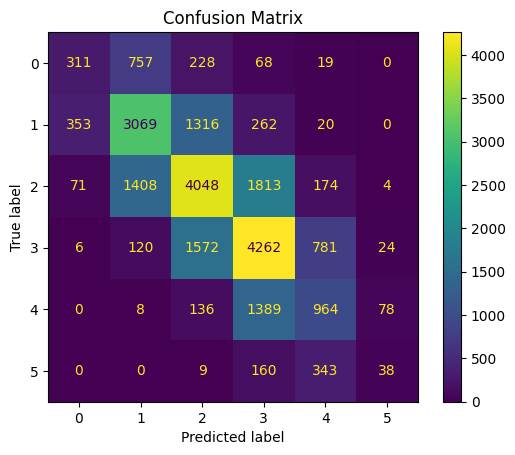

In [15]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [16]:
# wandb.finish()

CV/qwk_score,▁
eval/eval_epoch_f0,▁█
eval/eval_epoch_f1,▁█
eval/eval_epoch_f2,▁█
eval/eval_epoch_f3,▁█
eval/eval_epoch_f4,▁█
eval/eval_epoch_f5,▁█
eval/eval_epoch_f6,▁█
eval/eval_loss_f0,█▁
eval/eval_loss_f1,▁█
eval/eval_loss_f2,█▁
